# 10. 번역기를 만들어보자

## 10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

In [1]:
import tensorflow as tf

print(tf.__version__)

2.6.0


In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import re

In [3]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
66768,The dishwasher's broken.,Le lave-vaisselle est cassé.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
123657,I had a job when I was your age.,J'ai eu un boulot lorsque j'avais votre âge.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
14523,I want that one.,Je veux celui-là.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
16307,Tom is truthful.,Tom est franc.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
66992,They adopted the orphan.,Ils adoptèrent l'orphelin.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [4]:
lines = lines[['eng', 'fra']][:33000] # 33,000개 샘플 사용
lines.sample(10)

,eng,fra
2839,Can you ski?,Sais-tu faire du ski ?
2165,I'm so fat.,Je suis tellement gros.
5790,Stir it well.,Mélange-le bien !
16619,We have to stop.,Nous devons nous arrêter.
30209,I still enjoy that.,J'y prends toujours plaisir.
30389,I was very nervous.,J'étais très nerveux.
16859,What do you see?,Que voyez-vous ?
16820,We're unrelated.,Nous ne sommes pas apparentées.
23210,Hang up the phone.,Raccroche.
32511,Tom didn't help me.,Tom ne m'a pas aidé.


In [5]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
10619,I love cooking.,\t J'adore cuisiner. \n
31076,It's just too soon.,\t C'est juste trop tôt. \n
31961,The concert's over.,\t Le concert est fini. \n
27154,We need to escape.,\t Nous devons nous échapper. \n
676,I'm lost.,\t Je suis paumé. \n


정규표현식 먼저 해주고 (?><!@#$%^&*() 분리하고

그다음에 토크나이저해주기

## Step 1. 정제, 정규화, 전처리(영어, 프랑스어 모두)

#### 1. 구두점을 단어와 분리하기
#### 2. 소문자로 바꾸기
#### 3. 띄어쓰기 단위로 토큰 수행하기

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.


## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [6]:
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'
#정규표현식 할때 r은 붙여주자

lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)

In [7]:
eng_tokenizer = Tokenizer(filters='\t\n',
                          split= ' ',
                          char_level=False,
                          lower = True)             # 문자 단위로 Tokenizer를 생성합니다. char_level = False  
eng_tokenizer.fit_on_texts(lines.eng)               #
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[25, 1], [25, 1], [25, 1]]

In [8]:
type(input_text)

list

In [9]:
lines['eng'][17459]

'Are you the boss ? '

In [10]:
input_text[17459]

[16, 4, 10, 467, 3]

In [11]:
input_text_1 = eng_tokenizer.sequences_to_texts(input_text)   # 시퀀스를 text로 변환

In [12]:
input_text_1[17459]

'are you the boss ?'

In [13]:
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'
#정규표현식 할때 r은 붙여주자

lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)

In [14]:
fra_tokenizer = Tokenizer(filters='',
                          split= ' ',
                          char_level=False,
                          lower = True)              # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 64, 8, 2], [1, 356, 3, 2], [1, 26, 504, 8, 2]]

In [15]:
lines['fra'][8303]

'\t Non  ,   tu ne peux pas  .   \n'

In [16]:
target_text[8303]

[1, 191, 36, 18, 16, 60, 11, 3, 2]

In [17]:
target_text_1 = fra_tokenizer.sequences_to_texts(target_text)  

In [18]:
target_text_1[8303]

'\t non , tu ne peux pas . \n'

In [19]:
target_text_1

['\t va ! \n',
 '\t marche . \n',
 '\t en route ! \n',
 '\t bouge ! \n',
 '\t salut ! \n',
 '\t salut . \n',
 '\t cours\u202f ! \n',
 '\t courez\u202f ! \n',
 '\t prenez vos jambes à vos cous ! \n',
 '\t file ! \n',
 '\t filez ! \n',
 '\t cours ! \n',
 '\t fuyez ! \n',
 '\t fuyons ! \n',
 '\t cours\u202f ! \n',
 '\t courez\u202f ! \n',
 '\t prenez vos jambes à vos cous ! \n',
 '\t file ! \n',
 '\t filez ! \n',
 '\t cours ! \n',
 '\t fuyez ! \n',
 '\t fuyons ! \n',
 '\t qui ? \n',
 '\t ça alors\u202f ! \n',
 '\t waouh\xa0 ! \n',
 '\t wah\xa0 ! \n',
 '\t à terre\xa0 ! \n',
 '\t baisse - toi\xa0 ! \n',
 '\t baissez - vous\xa0 ! \n',
 '\t au feu ! \n',
 "\t à l'aide\u202f ! \n",
 '\t cache - toi . \n',
 '\t cachez - vous . \n',
 '\t saute . \n',
 '\t saute . \n',
 '\t ça suffit\u202f ! \n',
 '\t stop\u202f ! \n',
 '\t arrête - toi ! \n',
 '\t attends ! \n',
 '\t attendez ! \n',
 '\t attendez . \n',
 '\t attends ! \n',
 '\t attendez ! \n',
 '\t attends . \n',
 '\t attendez . \n',
 '\t comme

In [20]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 10021


In [21]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [22]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 10021
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [23]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [24]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 64, 8], [1, 356, 3], [1, 26, 504, 8]]
[[64, 8, 2], [356, 3, 2], [26, 504, 8, 2]]


In [25]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [26]:
print(encoder_input[0])

[25  1  0  0  0  0  0  0]


In [27]:
# # 원핫인코딩 

# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

In [28]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 16)


## Step 4. 임베딩 층(Embedding layer) 사용하기

인코더 설계

In [29]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

hidden_state = 256
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 128)(encoder_inputs)  # 단어장의 크기, 임베딩 벡터의 차원
enc_masking= Masking(mask_value=0.0)(enc_emb)#######
encoder_lstm = LSTM(hidden_state, return_state=True) #hidden state의 크기
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)#### enc_emb

encoder_states = [state_h, state_c]

디코더 설계

In [30]:
from keras import regularizers
# from keras.regularizers import l2

hidden_state = 256

decoder_inputs = Input(shape=(None, ))
dec_emb =  Embedding(fra_vocab_size, 128)(decoder_inputs) 
decoder_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
#                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))
# decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

In [31]:

decoder_batchnorm = tf.keras.layers.LayerNormalization()(decoder_outputs)
# decoder_dropout = tf.keras.layers.Dropout(0.5)#0.3
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
# decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax' , 
#                              kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001),
#     bias_regularizer=regularizers.L2(0.001),
#     activity_regularizer=regularizers.L2(0.001))

decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Step 5. 모델 구현하기

In [32]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001 ) # Adam 1.34

In [33]:
tf.random.set_seed(1)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [34]:
model.compile(optimizer=opt, 
              loss="sparse_categorical_crossentropy" , 
              metrics=['accuracy'])


# 원-핫 인코딩 하지 않아서
# sparse_categorical_crossentropy를 사용해준다

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    615680      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1282688     input_2[0][0]                    
______________________________________________________________________________________________

In [47]:
hist= model.fit(x=[encoder_input_train, decoder_input_train], 
                y=decoder_target_train, 
                validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                batch_size=128, 
                epochs=50)

## learning_rate = 0.0001 
## batch 32

Epoch 1/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9877 - accuracy: 0.8355 - val_loss: 1.4296 - val_accuracy: 0.7901
Epoch 2/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9745 - accuracy: 0.8369 - val_loss: 1.4207 - val_accuracy: 0.7910
Epoch 3/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9620 - accuracy: 0.8380 - val_loss: 1.4148 - val_accuracy: 0.7926
Epoch 4/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9498 - accuracy: 0.8390 - val_loss: 1.4113 - val_accuracy: 0.7929
Epoch 5/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9383 - accuracy: 0.8397 - val_loss: 1.4046 - val_accuracy: 0.7945
Epoch 6/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9268 - accuracy: 0.8408 - val_loss: 1.4013 - val_accuracy: 0.7947
Epoch 7/50
235/235 [==============================] - 8s 35ms/step - loss: 0.9158 - accuracy: 0.8417 - val_loss: 1.3964 - val_accuracy: 0.7954

In [48]:
# test_loss, test_accuracy = model.evaluate(decoder_input_test, decoder_target_test, verbose=2)
# print(f"test_loss: {test_loss}")
# print(f'test_accuracy: {test_accuracy}')

In [49]:
history_dict = hist.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


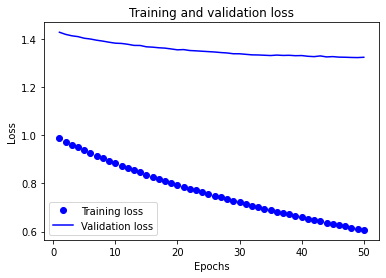

In [50]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

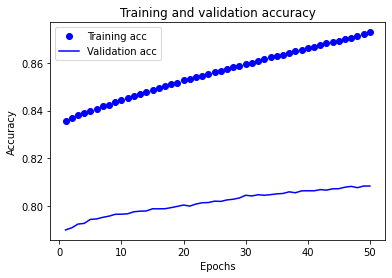

In [51]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 6. 모델 평가하기

In [52]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         615680    
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 394240    
Total params: 1,009,920
Trainable params: 1,009,920
Non-trainable params: 0
_________________________________________________________________


In [53]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]



In [54]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1282688     input_2[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [55]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [68]:
import numpy as np
for seq_index in [894,563,3856,45,60,234]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Come over . 
정답 문장:  Viens chez nous   !   
번역기가 번역한 문장:  venez ici . 
-----------------------------------
입력 문장: Go ahead . 
정답 문장:  Allez  -  y   !   
번역기가 번역한 문장:  allons - y ! 
-----------------------------------
입력 문장: Talk to Tom . 
정답 문장:  Parle à Tom   !   
번역기가 번역한 문장:  laisse tom . 
-----------------------------------
입력 문장: Begin . 
정답 문장:  Commencez  .   
번역기가 번역한 문장:  commençons . 
-----------------------------------
입력 문장: Relax . 
정답 문장:  Détends  -  toi   !   
번역기가 번역한 문장:  détends - toi ! 
-----------------------------------
입력 문장: Get out ! 
정답 문장:  Dégage   !   
번역기가 번역한 문장:  va ! 


###### 번역기 결과

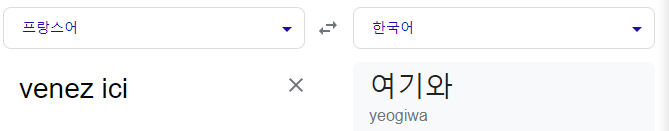

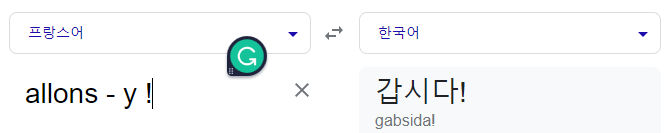

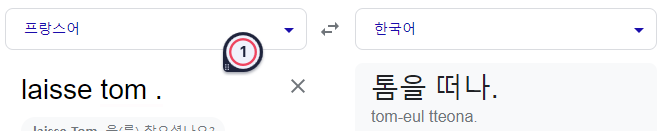

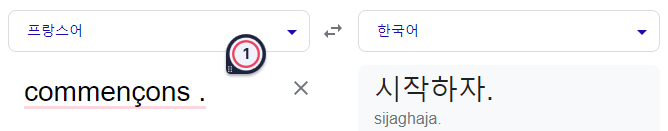

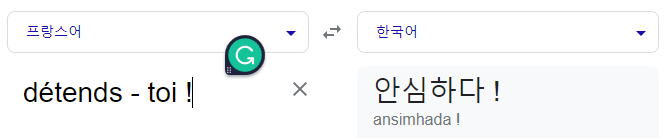

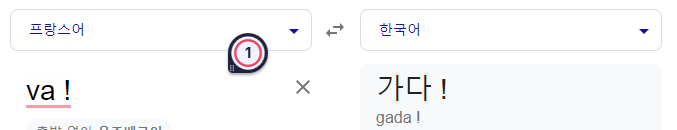

정답문장과 완벽하게 일치하는 문장은 없었지만,

구글 번역기를 사용해보니 대충 비슷한 의미를 가지게 번역된것들이있었다.

# 회고

- 이번 프로젝트에서 **어려웠던 점,**

전처리하는 과정과 정규화하는 과정이 어려웠다.

- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

char_level= True가 알파벳단위로 하는 문자수준이라는것

Tokenizer 파라미터 값들을 더 자세히 알았다

LayerNormalization도 사용해보고 Dropout도 적용해보았다

오버피팅 방지하기위해 다양한 방법을 더 찾아서 적용해보고싶다


시도를 하면서 꽤나 괜찮은 값이 나왔다고 생각했는데,

번역기를 돌려서 확인해보니 결과가 좋지않아서 마음이 불편하다.

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

전처리 과정과 정규화과정을 신경썼고 

모델이 잘 돌아가고 그래프가 우하향 하는 경향을 보이도록 신경썼다



- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.낌

val_loss 그래프가 우하향하지만 loss값이 꽤나 큰것이 아쉽다


- **자기 다짐**

오버피팅을 방지하기위해 다양한 방법을 적용해보는 시도를 하면 좋을 것 같다

옵티마이저도 다양하게 적용해보고 하이퍼파라미터값을 바꾸면서 

loss값을 줄일 수 있는 방법을 찾아 보고싶다

https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

https://keras.io/api/layers/regularizers/